# Paper / EC Consultancy Project
Felix Zaussinger | 17.01.2022

## Core Analysis Goal(s)
1. Analyse whether the distribution of occupation classes (G/B/N) at the ISCO-08 3-digit level is meaningful
2. Analyse whether the G/B/N mapping is robust enough (manual task)
    - appropriate threshold of greenness for an occupation to be green?
    - potential problems with mapping of brown occupations

3.

## Key Insight(s)
1.
2.
3.

In [1]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy
import scikit_posthocs as sp

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

Define directory structure

In [2]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

#### Pre-processing

Metadata

In [3]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA_gbn.csv"),
    index_col=0
)

ISCO occupation titles

In [4]:
df_isco = pd.read_csv(
    os.path.join(data_raw, "mcc_data", "processed", "ISCO_occupation_titles.csv")
)

df_isco

,isco,isco_title,level
0,1,Managers,1
1,2,Professionals,1
2,3,Technicians and associate professionals,1
3,4,Clerical support workers,1
4,5,Service and sales workers,1
...,...,...,...
604,9621,"Messengers, package deliverers and luggage por...",4
605,9622,Odd job persons,4
606,9623,Meter readers and vending-machine collectors,4
607,9624,Water and firewood collectors,4


In [5]:
retain_cols = [
    "id", "concept_uri", "preferred_label", "onet_code", "onet_occupation",
    "isco_level_1", "isco_level_2", "isco_level_3", "isco_level_4",
    "greenness_vona_2018_v2", "job_zone", "is_brown", "is_green", "is_neutral"
]

df_metadata_sub = df_metadata[retain_cols]

C:\Users\fzaussinger\AppData\Local\Temp\ipykernel_2068\2547396342.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sum = df_metadata_sub.groupby(group_var)["is_brown", "is_green", "is_neutral"].sum()


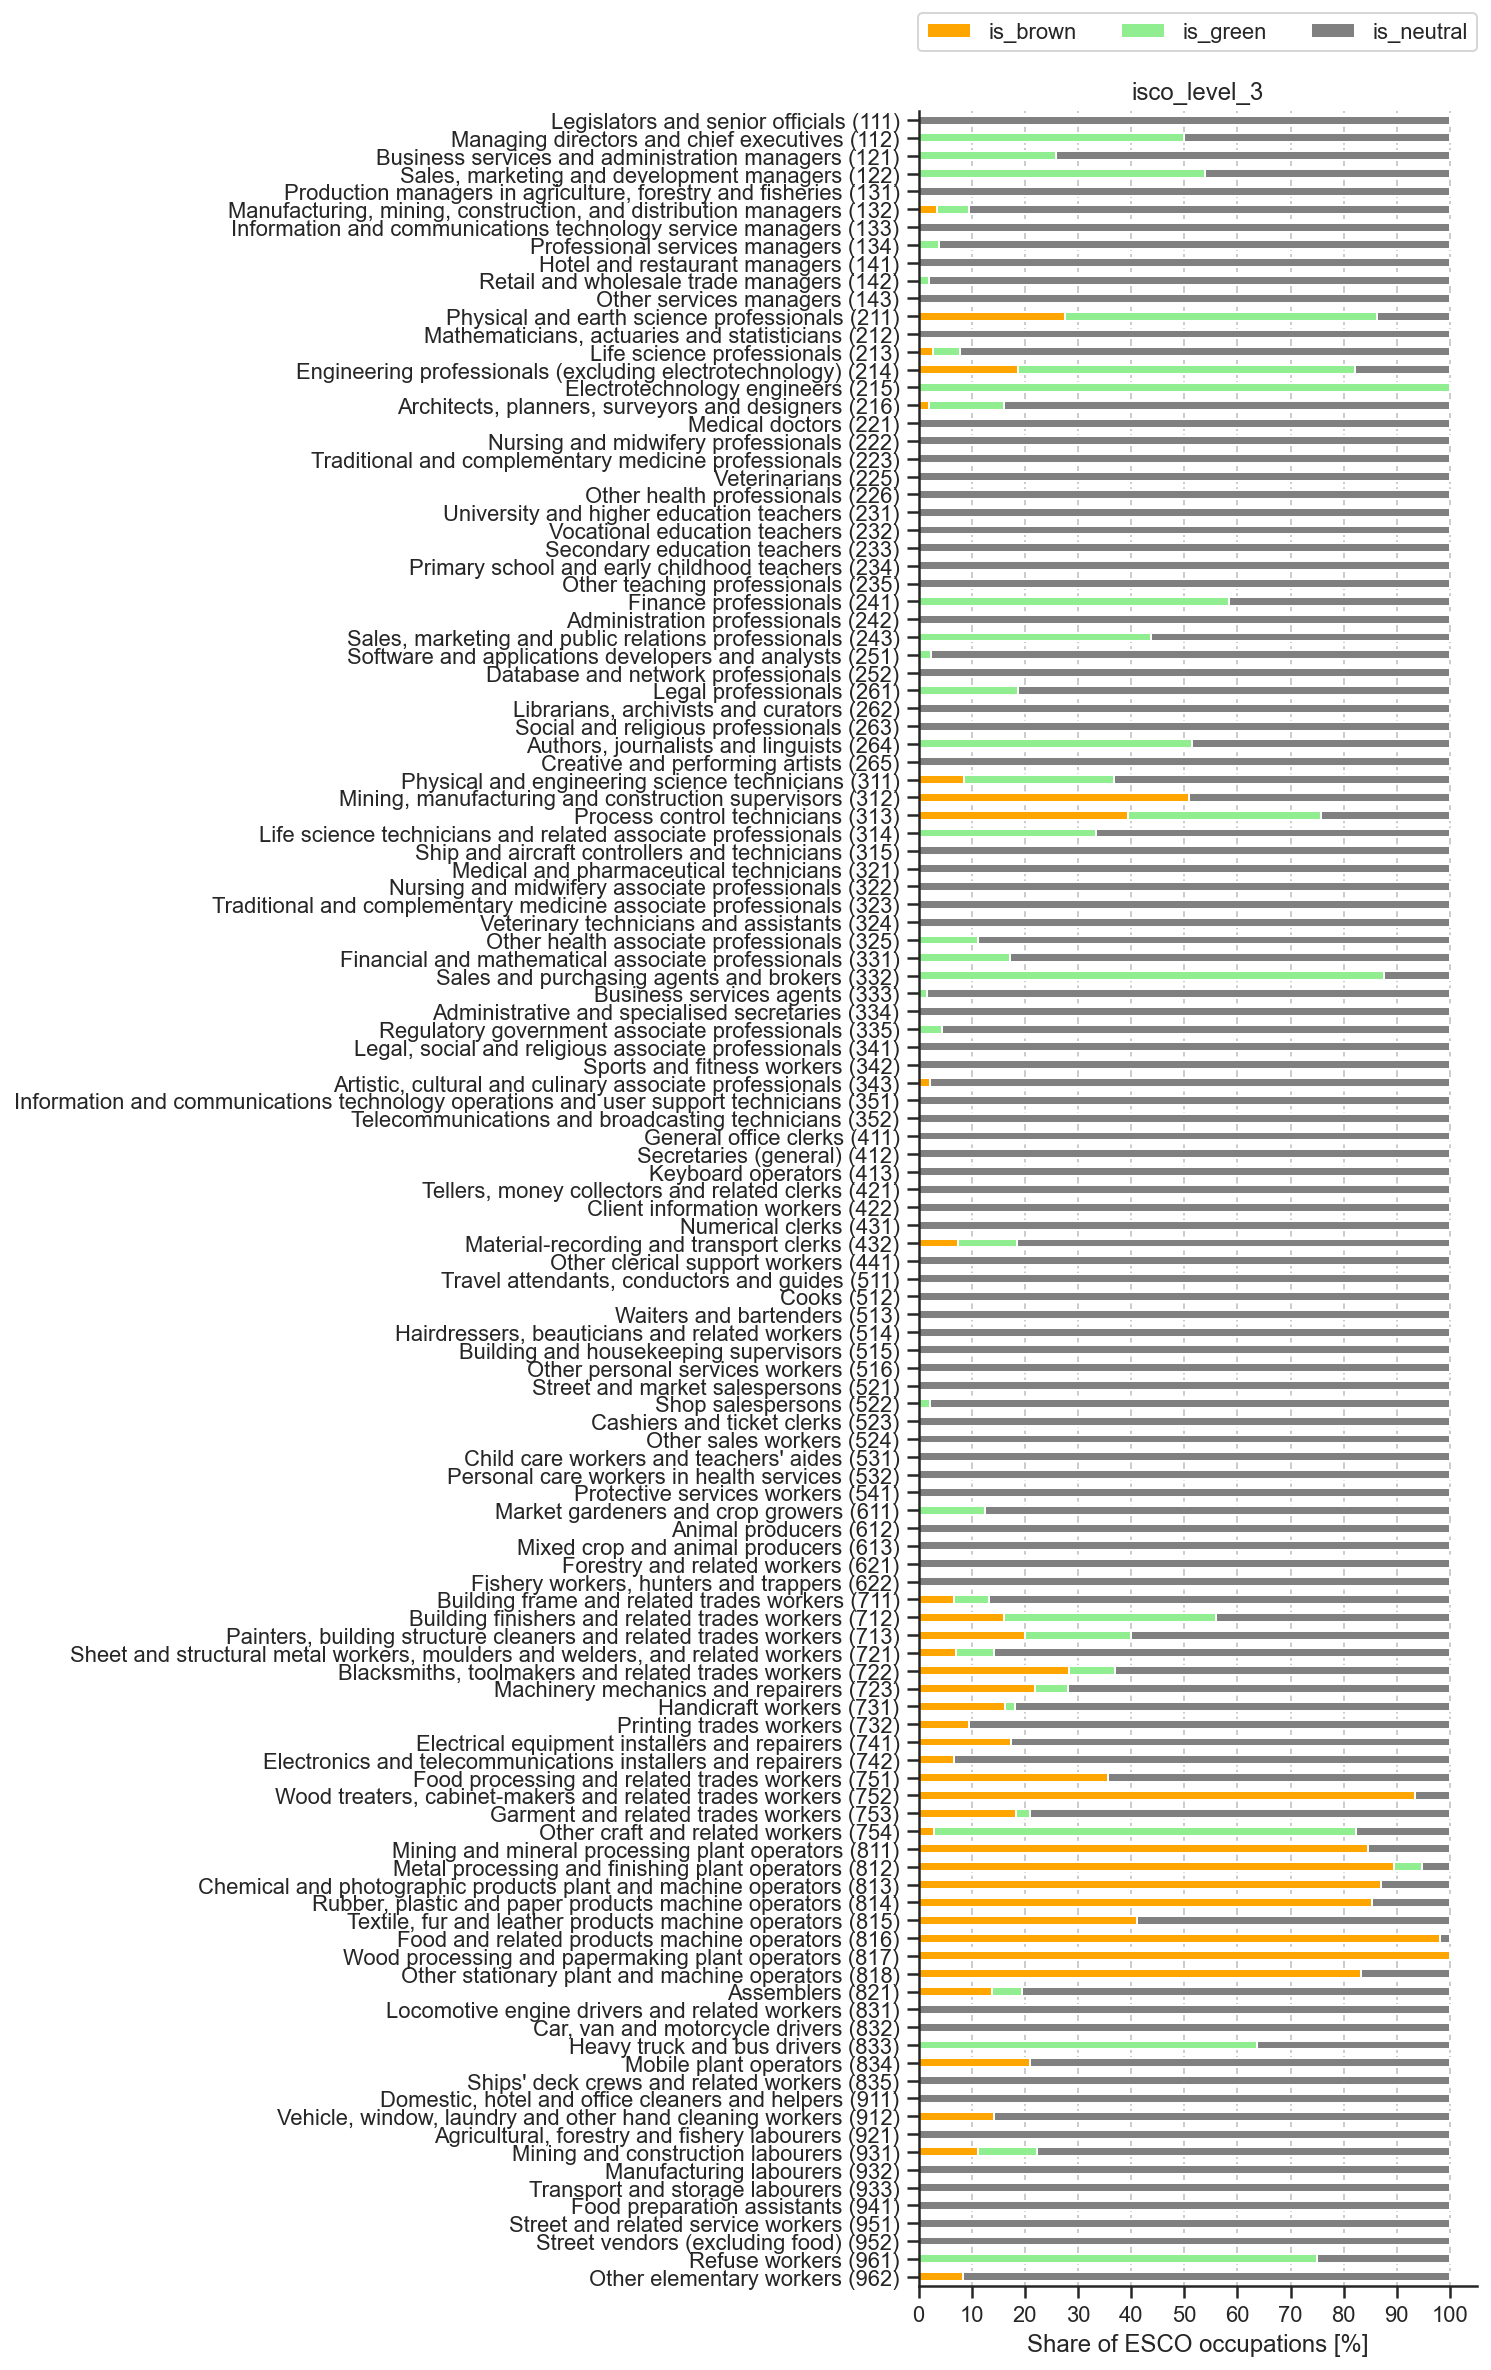

In [6]:
# select ISCO level
group_var = "isco_level_3"

# calculate shares of ESCO jobs per ISCO group
df_sum = df_metadata_sub.groupby(group_var)["is_brown", "is_green", "is_neutral"].sum()
df_share = df_sum.div(df_sum.sum(axis=1), axis=0)

# merge
df_out = pd.merge(
    df_share.reset_index(),
    df_isco,
    left_on=group_var,
    right_on="isco",
    how="left"
)

# create ylabel
new_ylabel = df_out.isco_title + " (" + df_out.isco.astype(str) + ")"
df_out["isco_title_new"] = new_ylabel

# prepare for plotting
df_plot = df_out.set_index("isco_title_new")[["is_brown", "is_green", "is_neutral"]]
df_plot *= 100

# plot
fig, ax = plt.subplots(figsize=(5, 20))
df_plot[::-1].plot.barh(stacked=True, color=["orange", "lightgreen", "grey"], ax=ax)

# styling
ax.set_title(group_var)
ax.set_ylabel(None)
ax.set_xticks(np.arange(0, 110, 10))
ax.set_xlabel("Share of ESCO occupations [%]")
ax.grid(axis="x", linestyle="--")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3)
sns.despine()

# save
fname = "esco_occ_shares_gbn_{}.png".format(group_var)

plt.savefig(
    os.path.join(figure_dir, "ec_paper", fname),
    bbox_inches="tight",
    dpi=150
)